In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'stix'

device = torch.device("cpu")

### Define network

In [2]:
class STM(nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        Initialize the attributes of STM.
        """
        super(STM, self).__init__() # inherit the __init__ from nn.Module.
        
        self.input=torch.rand(D_in)            
        self.linear1=nn.Linear(D_in, H)
        self.linear2=nn.Linear(H, D_out)
        self.x = self.init_x()            # initialize self.x with method init_x().
        
    def init_x(self):
        """
        Initialize self.x with two neurons.
        """
        return nn.Parameter(self.input)
        
    def forward(self):
        """
        Forward propagation.
        """
        h_relu = self.linear1(self.x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        
        return y_pred

### Predefined parameters

In [3]:
# Average energy
E_mean=5
# D_in=Input dimensions, H=Hidden dimension, D_out=Number of classes
D_in, H, D_out = 2, 100, 64
# Learning rate
lr=0.1
# Number of optimization
num_ops=5000

### Predefined data

In [4]:
# Lagrange multiplier
l = torch.tensor(0., requires_grad=True, dtype=torch.float32)
mu = 0.1

# Artifical energy levels
E=np.array([(i+1)**2 for i in range(D_out)])
E=torch.tensor(E, requires_grad=False, dtype=torch.float32)

# Target distribution
y=torch.ones(D_out)/D_out

### Predefined functions

In [5]:
softmax=torch.nn.Softmax(dim=-1)

### Building model

In [6]:
model = STM(D_in, H, D_out)

loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

### Plot probability distribution before training

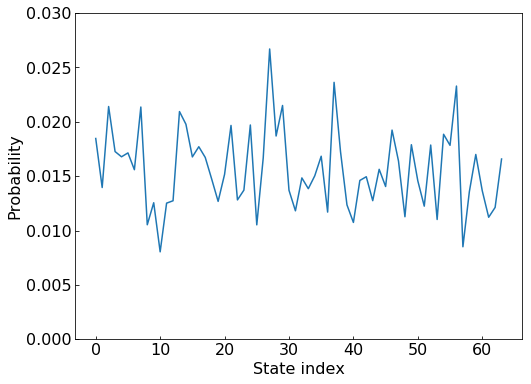

In [7]:
# Data
init_dist = softmax(model()).detach().numpy()

# Plot
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(init_dist)
ax.set_xlabel('State index', size=16)
ax.set_ylabel('Probability', size=16)
ax.set_ylim(0.0,0.03)
ax.tick_params(axis='both', which='major', direction='in', labelsize=16)
plt.show()

### Average energy before training

In [8]:
torch.mean(E*softmax(model()))

tensor(21.1842, grad_fn=<MeanBackward0>)

### Training

In [9]:
for i in range(num_ops):
    
    Y=model()
    loss = loss_fn(y,softmax(Y)) + 0.5*mu*(torch.mean(E*softmax(Y))-E_mean)**2
    
    if i % 500 == 499:
        print(i, loss.item())
    
    model.zero_grad()
    
    loss.backward()
    
    with torch.no_grad():
        for param in model.parameters():
            param -= lr * param.grad
    

499 0.0172269307076931
999 0.016126498579978943
1499 0.015836341306567192
1999 0.015676960349082947
2499 0.01556769385933876
2999 0.015484350733458996
3499 0.015420632436871529
3999 0.01537218876183033
4499 0.015334582887589931
4999 0.01530440803617239


### Plot probability distribution after training

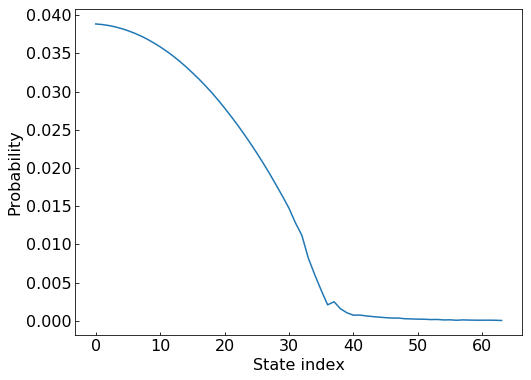

In [10]:
# Data
final_dist = softmax(model()).detach().numpy()

# Plot
fig, ax=plt.subplots(figsize=(8,6))
ax.plot(final_dist)
ax.set_xlabel('State index', size=16)
ax.set_ylabel('Probability', size=16)
# ax.set_ylim(0.0,0.03)
ax.tick_params(axis='both', which='major', direction='in', labelsize=16)
plt.show()

### Average energy after training

In [11]:
torch.mean(E*softmax(model()))

tensor(5.0319, grad_fn=<MeanBackward0>)

### Constraint term after traiing

In [12]:
torch.mean(E*softmax(model()))-E_mean

tensor(0.0319, grad_fn=<SubBackward0>)